In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from numpy.linalg import inv
import sys

sys.path.append('../../')
from PortfolioAnalysis import Backtest
from PortfolioAnalysis import Model

In [2]:
class BL:
    '''
    Black-Litterman is used to get the final combination weight
    Input:
    
    
    
    '''
    
    def __init__(self, df_date, df_history, df_fr, market_view, sub_view, Q,tau=1, LC=np.array([[0.8]])):
        self.df_date = df_date
        self.df_history = df_history
        self.df_fr = df_fr
        self.num = self.df_history.shape[1]
        self.Q = Q

        self.market_view = np.array(market_view)
        self.sub_view = np.array(sub_view)        
        
        # 风险厌恶系数
        df_r = np.log(df_history/df_history.shift(1)).dropna()
        market_r = (self.market_view*np.array(df_r))
        E_r = market_r.sum(axis = 1).sum(axis = 0)
        mean_fr = df_fr.mean()
        market_sigma = np.std(market_r.sum(axis=1))
        Lambda = ((E_r-mean_fr)/(market_sigma))[0]
        self.Lambda = Lambda
        
        
        
        # 先验收益率（n*1） = Lambda*协方差矩阵（n*n）*权重（n*1）
        market_cov = np.array(df_r.corr())
        Prod = Lambda * np.dot(market_cov , market_view.T)
        self.Prod = Prod
        
        
        # 观点误差矩阵
        P = (sub_view.sum(axis=0))
        CF = np.dot(np.dot(P,market_cov),P.T)
        Omega = CF/LC
        self.Omega = Omega

        
        # 后验收益率 E(R)
        E_R = np.dot(np.linalg.inv(inv(tau*market_cov)+\
                                   np.dot(np.dot(sub_view.T,inv(Omega)),sub_view)),
                         np.dot(inv(tau*market_cov),Prod)+\
                              np.dot(np.dot(sub_view.T,inv(Omega)),Q))
        self.E_R = E_R
        
        # BL协方差矩阵
        Cov_BL = inv(inv(tau*market_cov)+np.dot(np.dot(sub_view.T,inv(Omega)),sub_view))
        self.Cov_BL = Cov_BL
    
    def optimize(self, output=True):
        
        def utility(w):
            u = (w.T.dot(self.E_R)-(self.Lambda/2)*np.dot(w.T,self.Cov_BL).dot(w))
            return -u
        
        
        w = np.array([1/self.num,]*self.num)
        
        a = "{'type': 'eq', 'fun': lambda w: w.sum() - 1 }"
        for i in range(self.num):
            a = a + ",{'type': 'ineq', 'fun': lambda w: 1 - w["+str(i)+"] }" + \
            ",{'type': 'ineq', 'fun': lambda w: w["+str(i)+"] + 0.2}"
    
        cons = (eval(a))
        
        # optimization
        res = minimize(utility,w,constraints=cons,tol = 1e-10)
        
        # output
        if output:
            print("Status: "+str(res.message))
        return res.x
        
        

In [3]:
market_view = pd.read_csv("../Risk_Parity_Model/view.csv",index_col = 0)
sub_view = pd.read_csv("../Subjective_View_Setting/Subjective_View.csv",index_col = 0)
df_history = pd.read_excel("../../Data/Index.xls",index_col=0).dropna()
df_history.drop(["信息技术指数","金融指数","中债-国开行债券总财富(7-10年)指数","可选消费指数","房地产指数"],axis=1,inplace=True)


df_date = market_view.index
df_fr = pd.DataFrame(np.repeat(0,1134))

In [4]:
df_fr.shape

(1134, 1)

In [5]:
BL_weight = []
start = 0
while(1):
    print("count = %d"%int(start/63))
    if(start+63>len(df_date)):
        break
    market_view_rw = np.array(market_view.iloc[start,:])
    sub_view_rw = np.array(sub_view.iloc[start,:-1]).reshape(1,15)
    Q = np.array([sub_view.iloc[start,-1]])

    BLM = BL(df_date[start:start+63], df_history[start:start+252*6], df_fr[start:start+63],market_view_rw, sub_view_rw, Q,tau=1.2)

    BL_weight.append(BLM.optimize())
    start+=63

count = 0
Status: Optimization terminated successfully.
count = 1
Status: Optimization terminated successfully.
count = 2
Status: Optimization terminated successfully.
count = 3
Status: Optimization terminated successfully.
count = 4
Status: Optimization terminated successfully.
count = 5
Status: Optimization terminated successfully.
count = 6
Status: Optimization terminated successfully.
count = 7
Status: Optimization terminated successfully.
count = 8
Status: Optimization terminated successfully.
count = 9
Status: Optimization terminated successfully.
count = 10
Status: Optimization terminated successfully.
count = 11
Status: Optimization terminated successfully.
count = 12
Status: Optimization terminated successfully.
count = 13
Status: Optimization terminated successfully.
count = 14
Status: Optimization terminated successfully.
count = 15
Status: Optimization terminated successfully.
count = 16
Status: Optimization terminated successfully.
count = 17
Status: Optimization terminate

In [6]:
view = np.array(BL_weight)
view = np.repeat(view,63,axis=0)

In [7]:
BT = Backtest.Backtest(df_date, df_history[252*6:252*6+63*18], pd.DataFrame(view), df_fr, 'D')
BT.get_info()

,Sharpe,Annualized Return,Annualized Volatility,Maximum Drawdown
Value,0.6668,0.041476,0.062202,0.046144


In [8]:
df_bm = pd.DataFrame(np.repeat(np.array([[1/15,]*15]),63*18,axis=0))

In [9]:
BTM = Backtest.Backtest(df_date, df_history[252*6:252*6+63*18], df_bm, df_fr, 'D')
BTM.get_info()

,Sharpe,Annualized Return,Annualized Volatility,Maximum Drawdown
Value,0.021748,0.025452,1.170299,0.298374


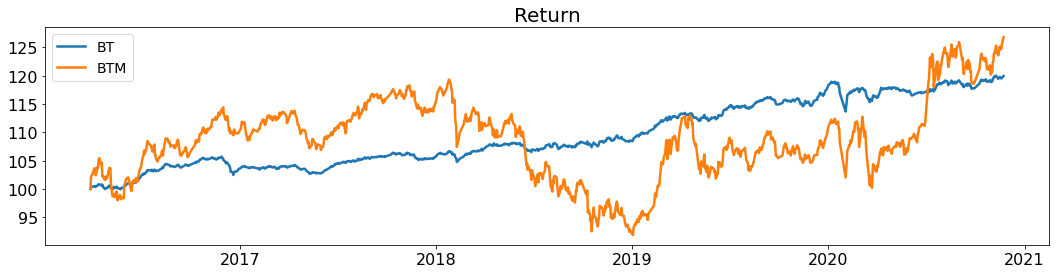

In [10]:
Backtest.Plot2(df_date,BT.df_asset,BTM.df_asset,"Return","BT","BTM")

In [11]:
Asset = pd.DataFrame([BT.df_asset,BTM.df_asset]).T
Asset.index = df_date
Asset.columns = ['BL','Market']

Asset.to_csv("BL_Asset.csv")

pd.DataFrame(view,index = df_date).to_csv("view.csv")